In [276]:
import pandas as pd
import seaborn as sns
import duckdb
import functions as f
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf


In [277]:
con = duckdb.connect("data.db")


In [278]:
oecd = con.sql("SELECT * FROM oecd").df() 
ecb = con.sql("SELECT * FROM ecb").df()         # Pandas DataFrame
eurostat = con.sql("SELECT * FROM eurostat").df()         # Pandas DataFrame
world_b = con.sql("SELECT * FROM world_bank").df()         # Pandas DataFrame


In [279]:
oecd.dtypes

DATE      object
GEO       object
LTIR     float64
STIR     float64
IIR      float64
CBAR     float64
UEMPR    float64
dtype: object

## DATA PREPARATION

- There is two different country abbrevation thorugh the data. In this section that is fixed to three letter abrevation and 
- the data merged via abbrevations and date 
- analyzed missing values and france selected as main data becasue it has the most non-null values

### Filtering

In [280]:
import pycountry

def convert_alpha2_to_alpha3(code):
    if not code or not isinstance(code, str):
        return code
    try:
        return pycountry.countries.get(alpha_2=code.upper()).alpha_3
    except:
        return code  # return original value if not ISO

    
eurostat['GEO'] = eurostat['GEO'].apply(convert_alpha2_to_alpha3)
eurostat['GEO'].unique()


array(['BRA', 'CAN', 'CHN', 'DEU', 'FRA', 'IDN', 'IND', 'ITA', 'JPN',
       'KOR', 'MEX', 'RUS', 'USA', 'ZAF', 'ARG', 'FIN', 'SAU', 'G20',
       'TUR', 'UK', 'BEL', 'EST', 'LTU', 'EA19', 'EU28', 'EU27_2020',
       'AUT', 'BGR', 'CHE', 'CYP', 'CZE', 'DNK', 'EA20', 'EL', 'ESP',
       'HRV', 'HUN', 'IRL', 'LUX', 'LVA', 'MNE', 'MLT', 'NLD', 'NOR',
       'POL', 'PRT', 'ROU', 'SRB', 'SVN', 'SVK', 'ALB', 'BIH', 'MKD',
       'SWE'], dtype=object)

In [281]:
import pandas as pd

def compare_columns(df1, df2, column_name):
    """
    Compare columns between two DataFrames and print common and uncommon columns.

    Parameters:
    - df1, df2: pandas DataFrames to compare
    """
    cols1 = set(df1[column_name])
    cols2 = set(df2[column_name])

    common = cols1 & cols2
    only_in_df1 = cols1 - cols2
    only_in_df2 = cols2 - cols1

    print("✅ Common columns:")
    print(sorted(common))
    print("\n🟥 Only in first DataFrame:")
    print(sorted(only_in_df1))
    print("\n🟦 Only in second DataFrame:")
    print(sorted(only_in_df2))

    return {
        "common": common,
        "only_in_df1": only_in_df1,
        "only_in_df2": only_in_df2
    }


In [282]:
col_names = compare_columns(oecd,eurostat,"GEO")

✅ Common columns:
['AUT', 'BEL', 'BGR', 'BRA', 'CAN', 'CHE', 'CHN', 'CZE', 'DEU', 'DNK', 'EA19', 'EA20', 'ESP', 'EST', 'EU27_2020', 'FIN', 'FRA', 'HRV', 'HUN', 'IDN', 'IND', 'IRL', 'ITA', 'JPN', 'KOR', 'LTU', 'LUX', 'LVA', 'MEX', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'RUS', 'SVK', 'SVN', 'SWE', 'TUR', 'USA', 'ZAF']

🟥 Only in first DataFrame:
['A5M', 'AUS', 'CHL', 'COL', 'CRI', 'G7', 'GBR', 'GRC', 'ISL', 'ISR', 'NZL', 'OECD', 'OECDE', 'OECDXEA']

🟦 Only in second DataFrame:
['ALB', 'ARG', 'BIH', 'CYP', 'EL', 'EU28', 'G20', 'MKD', 'MLT', 'MNE', 'SAU', 'SRB', 'UK']


In [283]:
def filter_geo(df, geo):
    """
    Filters a DataFrame by one or more GEO codes.

    Parameters:
    - df: pandas DataFrame
    - geo: a single GEO string or a list of GEO strings

    Returns:
    - Filtered DataFrame
    """
    if isinstance(geo, (list, tuple, set)):
        return df[df["GEO"].isin(geo)]
    else:
        return df[df["GEO"] == geo]


In [284]:
import pandas as pd

def null_counts_by_category(df, category_col, date_col='DATE'):
    """
    Calculates number of nulls and percentage of nulls in each column,
    grouped by values in a category column.

    Parameters:
    - df: pandas DataFrame
    - category_col: column name to group by (as string)
    - date_col: column used to count total entries per category (default='DATE')

    Returns:
    - DataFrame: index = category values, columns = original columns (with count and percentage),
                 plus 'avg_perct' column, sorted by 'avg_perct'.
    """
    if category_col not in df.columns:
        raise ValueError(f"Column '{category_col}' not found in DataFrame.")

    # Count unique occurrences for each category (denominator for %)
    total_counts = df.groupby(category_col)[date_col].nunique()

    # Count nulls
    null_counts = df.groupby(category_col).apply(lambda group: group.isnull().sum())
    null_counts = null_counts.drop(columns=[category_col], errors="ignore")

    # Calculate percentage of nulls for each column
    percentage_nulls = null_counts.div(total_counts, axis=0) * 100
    percentage_nulls = percentage_nulls.round(2).astype(str) + '%'

    # Calculate average percentage per row (as float)
    avg_perct = null_counts.div(total_counts, axis=0).mean(axis=1) * 100

    # Combine counts and percentages with avg_perct
    result = pd.concat([null_counts, percentage_nulls.add_suffix('_%')], axis=1)
    result['avg_perct'] = avg_perct.round(2)

    # Sort by average percentage
    result = result.sort_values(by='avg_perct')

    return result

In [285]:
null_counts_by_category(filter_geo(oecd,col_names["common"]),"GEO")

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_5507/1046894067.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  null_counts = df.groupby(category_col).apply(lambda group: group.isnull().sum())


,DATE,LTIR,STIR,IIR,CBAR,UEMPR,DATE_%,LTIR_%,STIR_%,IIR_%,CBAR_%,UEMPR_%,avg_perct
GEO,,,,,,,,,,,,,
LTU,0,33,9,9,38,1,0.0%,10.22%,2.79%,2.79%,11.76%,0.31%,4.64
CZE,0,87,0,0,25,1,0.0%,22.54%,0.0%,0.0%,6.48%,0.26%,4.88
USA,0,0,135,15,82,21,0.0%,0.0%,15.64%,1.74%,9.5%,2.43%,4.89
SVK,0,58,5,0,42,27,0.0%,16.48%,1.42%,0.0%,11.93%,7.67%,6.25
FIN,0,13,0,144,11,13,0.0%,2.84%,0.0%,31.44%,2.4%,2.84%,6.59
HUN,0,97,28,12,26,61,0.0%,23.66%,6.83%,2.93%,6.34%,14.88%,9.11
KOR,0,129,12,12,108,0,0.0%,30.57%,2.84%,2.84%,25.59%,0.0%,10.31
CAN,0,0,12,240,301,0,0.0%,0.0%,1.43%,28.5%,35.75%,0.0%,10.95
ESP,0,79,43,0,158,155,0.0%,12.72%,6.92%,0.0%,25.44%,24.96%,11.67


In [286]:
null_counts_by_category(filter_geo(eurostat,col_names["common"]),"GEO")

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_5507/1046894067.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  null_counts = df.groupby(category_col).apply(lambda group: group.isnull().sum())


,DATE,Retail_Volume,CPI,DATE_%,Retail_Volume_%,CPI_%,avg_perct
GEO,,,,,,,
DEU,0,2,0,0.0%,0.53%,0.0%,0.18
EU27_2020,0,2,0,0.0%,0.66%,0.0%,0.22
FRA,0,62,0,0.0%,16.58%,0.0%,5.53
ITA,0,74,0,0.0%,19.79%,0.0%,6.60
TUR,0,168,0,0.0%,48.28%,0.0%,16.09
KOR,0,374,0,0.0%,100.0%,0.0%,33.33
LTU,0,0,324,0.0%,0.0%,100.0%,33.33
LUX,0,0,300,0.0%,0.0%,100.0%,33.33
LVA,0,0,300,0.0%,0.0%,100.0%,33.33


In [287]:

df_merged_0 = filter_geo(eurostat,["FRA"]).merge(filter_geo(oecd,["FRA"]), on="DATE", how="outer")
df_merged_0

,DATE,GEO_x,Retail_Volume,CPI,GEO_y,LTIR,STIR,IIR,CBAR,UEMPR
0,1955-01,NaN,NaN,NaN,FRA,NaN,NaN,3.270000,NaN,NaN
1,1955-02,NaN,NaN,NaN,FRA,NaN,NaN,3.250000,NaN,NaN
2,1955-03,NaN,NaN,NaN,FRA,NaN,NaN,3.280000,NaN,NaN
3,1955-04,NaN,NaN,NaN,FRA,NaN,NaN,3.230000,NaN,NaN
4,1955-05,NaN,NaN,NaN,FRA,NaN,NaN,3.270000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
837,2024-10,FRA,-0.5,0.3,FRA,2.99,3.166609,3.371394,-0.154174,7.3
838,2024-11,FRA,0.2,-0.1,FRA,3.09,3.006762,3.164967,-0.386029,7.3
839,2024-12,FRA,-0.7,0.2,FRA,3.01,2.816091,3.102686,-0.372024,7.3
840,2025-01,FRA,-0.1,-0.2,FRA,3.32,2.703130,2.918839,0.575679,7.3


In [288]:
df_merged = df_merged_0.merge(world_b, on="DATE", how="outer")
df_merged

,DATE,GEO_x,Retail_Volume,CPI,GEO_y,LTIR,STIR,IIR,CBAR,UEMPR,POP_y
0,1955-01,NaN,NaN,NaN,FRA,NaN,NaN,3.270000,NaN,NaN,NaN
1,1955-02,NaN,NaN,NaN,FRA,NaN,NaN,3.250000,NaN,NaN,NaN
2,1955-03,NaN,NaN,NaN,FRA,NaN,NaN,3.280000,NaN,NaN,NaN
3,1955-04,NaN,NaN,NaN,FRA,NaN,NaN,3.230000,NaN,NaN,NaN
4,1955-05,NaN,NaN,NaN,FRA,NaN,NaN,3.270000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
837,2024-10,FRA,-0.5,0.3,FRA,2.99,3.166609,3.371394,-0.154174,7.3,NaN
838,2024-11,FRA,0.2,-0.1,FRA,3.09,3.006762,3.164967,-0.386029,7.3,NaN
839,2024-12,FRA,-0.7,0.2,FRA,3.01,2.816091,3.102686,-0.372024,7.3,NaN
840,2025-01,FRA,-0.1,-0.2,FRA,3.32,2.703130,2.918839,0.575679,7.3,NaN


### Handling missing values

In [289]:
import pandas as pd

# Assume df is your DataFrame and 'date' is your date column
df = df_merged.sort_values('DATE').reset_index(drop=True)  # Make sure it's sorted by date
# Identify numeric columns (excluding date)
numeric_cols = df.select_dtypes(include='number').columns

# Create a mask where all numeric values are NaN
all_nan_mask = df[numeric_cols].isnull().any(axis=1)
# Find first and last index where not all numeric values are NaN
first_valid_idx = df[~all_nan_mask].index[0]
last_valid_idx = df[~all_nan_mask].index[-1]

# Trim DataFrame from first to last valid index
df_trimmed = df.loc[first_valid_idx:last_valid_idx].copy()

# Fill missing values between using interpolation (or any other method)
df_filled = df_trimmed.copy()
df_filled[numeric_cols] = df_trimmed[numeric_cols].interpolate(method='linear')

# Optional: fill remaining nulls if interpolation didn't cover all
df_filled[numeric_cols] = df_filled[numeric_cols].fillna(method='bfill').fillna(method='ffill')


/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_5507/2430720086.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[numeric_cols] = df_filled[numeric_cols].fillna(method='bfill').fillna(method='ffill')


In [290]:
df_filled

,DATE,GEO_x,Retail_Volume,CPI,GEO_y,LTIR,STIR,IIR,CBAR,UEMPR,POP_y
529,1999-02,FRA,1.7,0.4,FRA,3.9377,3.093400,3.118000,0.030459,12.0,6.053671e+07
530,1999-03,FRA,0.8,0.3,FRA,4.1367,3.046696,2.925200,-0.182699,11.8,6.057143e+07
531,1999-04,FRA,-0.4,0.3,FRA,3.9893,2.696455,2.709100,-0.091516,11.7,6.060615e+07
532,1999-05,FRA,0.7,0.0,FRA,4.1686,2.578952,2.551000,0.030533,11.5,6.064088e+07
533,1999-06,FRA,0.0,0.0,FRA,4.4893,2.626682,2.563200,0.137358,11.4,6.067560e+07
...,...,...,...,...,...,...,...,...,...,...,...
811,2022-08,FRA,1.3,0.5,FRA,1.6900,0.394739,-0.094652,0.454176,7.2,6.806502e+07
812,2022-09,FRA,1.9,-0.5,FRA,2.4100,1.010864,0.254584,-0.545665,7.1,6.806502e+07
813,2022-10,FRA,-1.6,1.2,FRA,2.7700,1.427667,0.655379,0.250815,7.2,6.806502e+07
814,2022-11,FRA,-1.0,0.4,FRA,2.5800,1.825227,1.266620,0.328371,7.2,6.806502e+07


## Stationarity

<Axes: >

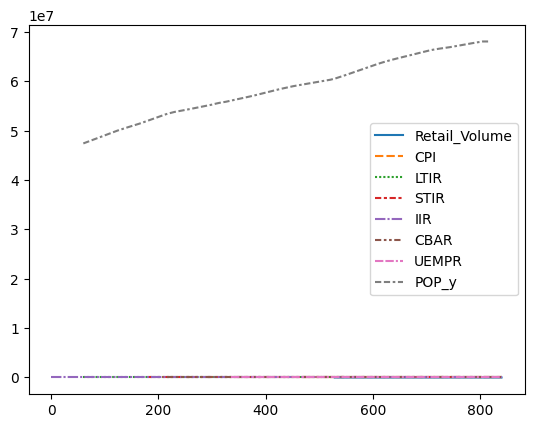

In [291]:
sns.lineplot(df_merged)

<Axes: >

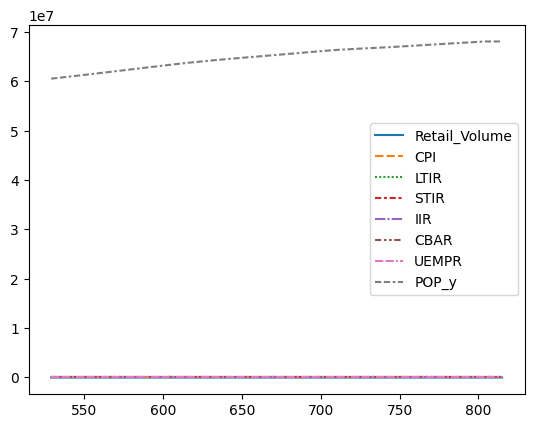

In [292]:
sns.lineplot(df_filled)

In [330]:
df_test = df_filled[['Retail_Volume', 'CPI', 'LTIR', 'STIR', 'IIR', 'CBAR', 'UEMPR',"POP_y"]]

In [294]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

def check_stationarity(df, signif=0.05):
    """
    Check stationarity for each numeric column using the Augmented Dickey-Fuller test.

    Parameters:
    - df: pandas DataFrame
    - signif: significance level (default: 0.05)

    Returns:
    - pd.DataFrame with columns: Test Statistic, p-value, Stationary (True/False)
    """
    results = []

    for col in df.select_dtypes(include='number').columns:
        series = df[col].dropna()
        if len(series) < 10:  # Too short for ADF test
            results.append([col, None, None, "Too few observations"])
            continue

        try:
            test_stat, p_val, _, _, _, _ = adfuller(series)
            is_stationary = p_val < signif
            results.append([col, round(test_stat, 4), round(p_val, 4), is_stationary])
        except Exception as e:
            results.append([col, None, None, f"Error: {str(e)}"])

    return pd.DataFrame(results, columns=["Column", "Test Statistic", "p-value", "Stationary"])


In [295]:
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

import pandas as pd

def check_stationarity_extended(df, signif=0.05, regression='c'):
    """
    Check stationarity for each numeric column using multiple tests:
    ADF, KPSS, PP, and DFGLS.

    Parameters:
    - df: pandas DataFrame with numeric columns.
    - signif: significance level (default=0.05)
    - regression: type of regression (default='c' → constant only).
                  Options: 'c' (constant), 'ct' (constant + trend), 'nc' (no constant)

    Returns:
    - pd.DataFrame: one row per column, one column per test result.
    """
    results = []

    for col in df.select_dtypes(include='number').columns:
        row = {"Column": col}
        series = df[col].dropna()

        if len(series) < 10:
            row.update({
                "ADF": "Too short",
                "KPSS": "Too short",
                "PP": "Too short",
                "DFGLS": "Too short"
            })
            results.append(row)
            continue

        # Augmented Dickey-Fuller
        try:
            adf_stat, adf_p, *_ = adfuller(series, regression=regression)
            row["ADF"] = adf_p < signif
        except Exception as e:
            row["ADF"] = f"Error: {str(e)}"

        # KPSS (note: here null = stationary)
        try:
            kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
            row["KPSS"] = kpss_p > signif  # fail to reject ⇒ stationary
        except Exception as e:
            row["KPSS"] = f"Error: {str(e)}"

        # Phillips-Perron
        try:
            pp_stat, pp_p = PhillipsPerron(series)
            row["PP"] = pp_p < signif
        except Exception as e:
            row["PP"] = f"Error: {str(e)}"


        results.append(row)

    return pd.DataFrame(results)


In [296]:
kpss(df_test["Retail_Volume"])

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_5507/876465652.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(df_test["Retail_Volume"])


(np.float64(0.14985364715929356),
 np.float64(0.1),
 43,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [297]:
check_stationarity(df_test)

,Column,Test Statistic,p-value,Stationary
0,Retail_Volume,-8.0955,0.0000,True
1,CPI,-1.7006,0.4308,False
2,LTIR,-1.2808,0.6379,False
3,STIR,-2.1485,0.2255,False
4,IIR,-1.7086,0.4267,False
5,CBAR,-5.9486,0.0000,True
6,UEMPR,-2.1306,0.2324,False


In [298]:
check_stationarity_extended(df_test)

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_5507/357669944.py:45: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_5507/357669944.py:45: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_5507/357669944.py:45: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression=regression)
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_5507/357669

,Column,ADF,KPSS,PP
0,Retail_Volume,True,True,Error: cannot unpack non-iterable PhillipsPerr...
1,CPI,False,True,Error: cannot unpack non-iterable PhillipsPerr...
2,LTIR,False,False,Error: cannot unpack non-iterable PhillipsPerr...
3,STIR,False,False,Error: cannot unpack non-iterable PhillipsPerr...
4,IIR,False,False,Error: cannot unpack non-iterable PhillipsPerr...
5,CBAR,True,True,Error: cannot unpack non-iterable PhillipsPerr...
6,UEMPR,False,True,Error: cannot unpack non-iterable PhillipsPerr...


## CCF and PCCF

In [327]:
df_test.columns

Index(['Retail_Volume', 'CPI', 'LTIR', 'STIR', 'IIR', 'CBAR', 'UEMPR',
       'POP_y'],
      dtype='object')

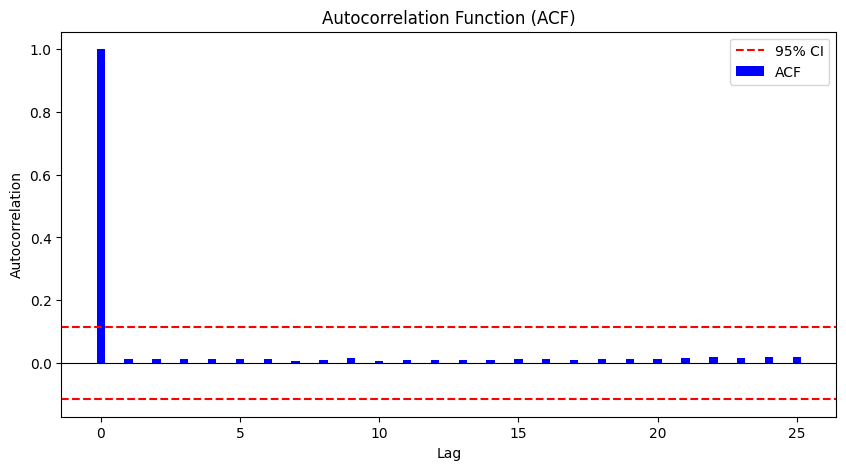

In [332]:
f.ccf_plot(df_test["Retail_Volume"],df_test["POP_y"],nlags=25)

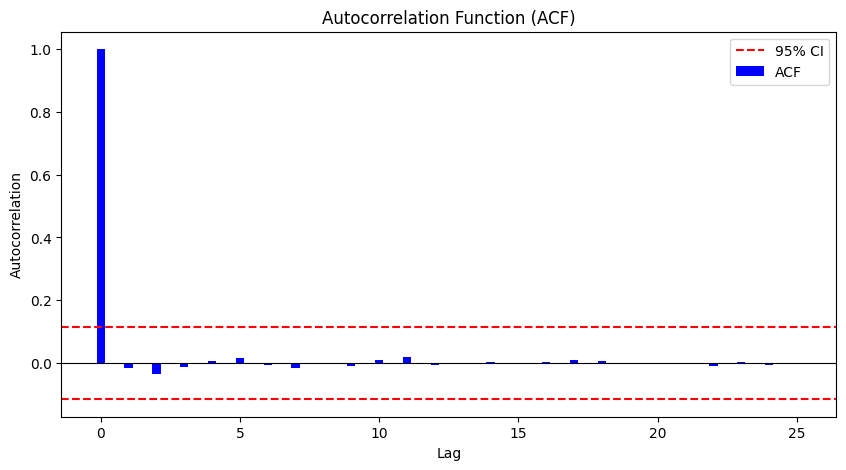

In [333]:
f.ccf_plot(df_test["Retail_Volume"],df_test["UEMPR"],nlags=25)

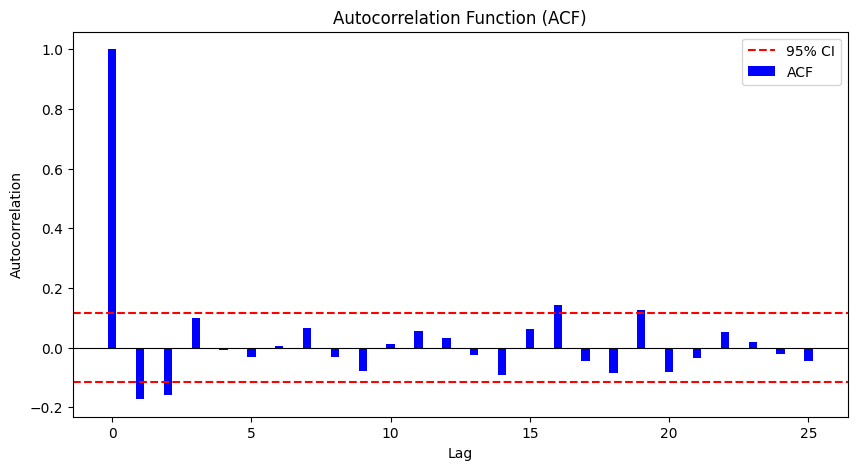

In [334]:
f.ccf_plot(df_test["Retail_Volume"],df_test["CBAR"],nlags=25)

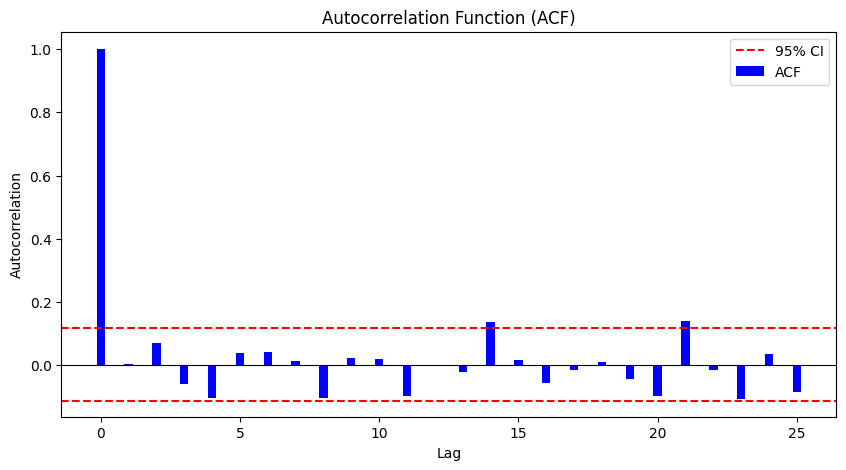

In [335]:
f.ccf_plot(df_test["Retail_Volume"],df_test["CPI"],nlags=25)

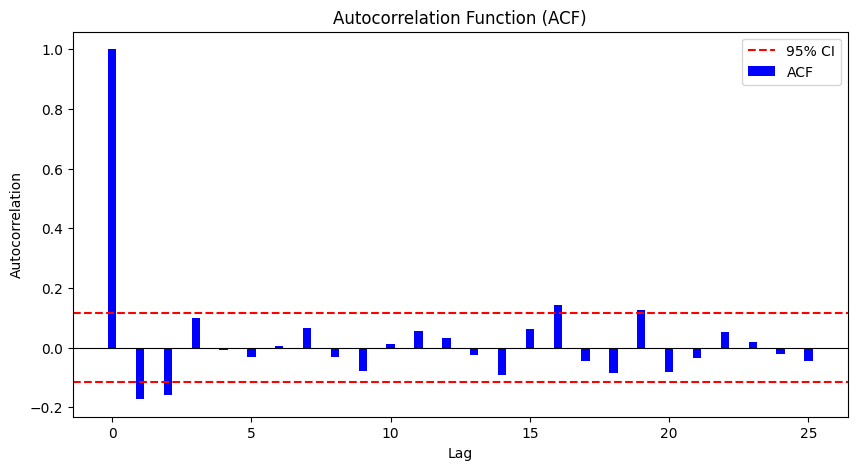

In [336]:
f.ccf_plot(df_test["Retail_Volume"],df_test["CBAR"],nlags=25)

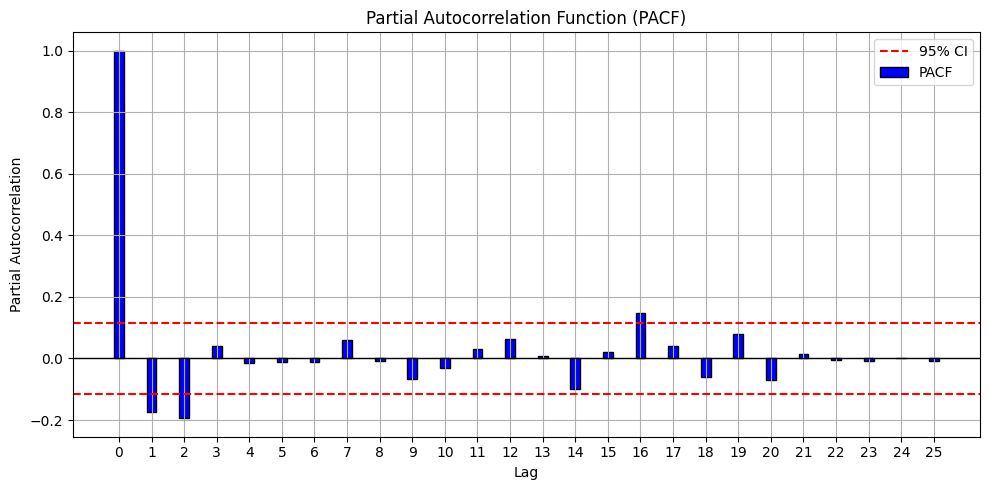

In [337]:
f.pccf_plot(df_test["Retail_Volume"],df_test["CBAR"],nlags=25)

## Causality

In [301]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

def plot_granger_causality_pvalues(df, maxlag, variables, alpha=0.05, verbose=False):
    """
    Run grangercausalitytests and plot p-values for each lag.

    Parameters:
    - df: DataFrame with two columns [Y, X] where X is tested as a cause of Y
    - maxlag: maximum lag to test
    - variables: tuple (Y, X) – names of the dependent and independent variables
    - alpha: significance level for rejection
    - verbose: if True, prints full test output
    """
    y_col, x_col = variables
    test_result = grangercausalitytests(df[[y_col, x_col]], maxlag=maxlag, verbose=verbose)

    p_values = []
    for lag in range(1, maxlag + 1):
        p_val = test_result[lag][0]['ssr_ftest'][1]  # extract p-value from F-test
        p_values.append(p_val)

    # Plot p-values
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, maxlag + 1), p_values, color='skyblue')
    plt.axhline(y=alpha, color='red', linestyle='--', label=f'Significance level ({alpha})')
    plt.xticks(range(1, maxlag + 1))
    plt.xlabel("Lag")
    plt.ylabel("p-value")
    plt.title(f"Granger Causality Test p-values: Does {x_col} → {y_col}?")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return p_values


/Users/emirysaglam/GitHub/Bitirme2/.venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


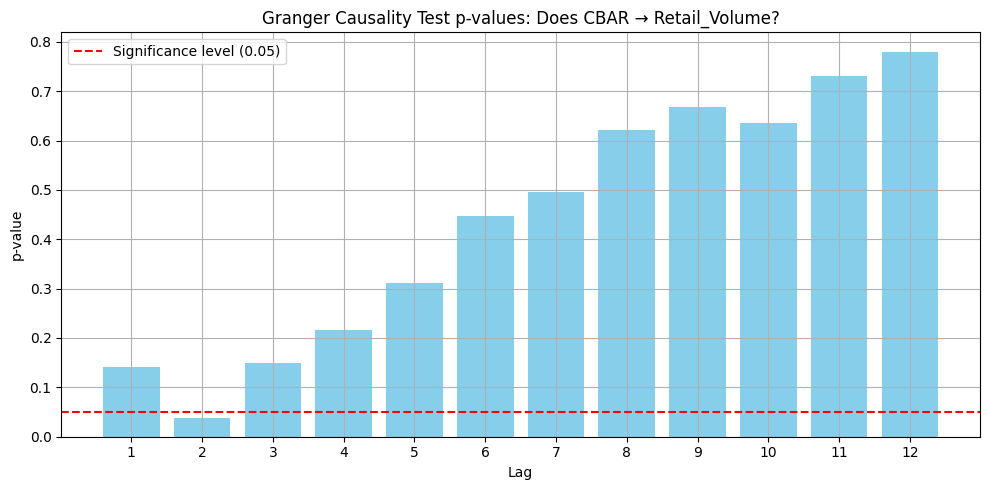

[np.float64(0.14181425757217755),
 np.float64(0.03734895445931497),
 np.float64(0.14917718928801924),
 np.float64(0.21586329923148484),
 np.float64(0.3107596338045549),
 np.float64(0.44740247198495475),
 np.float64(0.4947802887852),
 np.float64(0.6210143143879431),
 np.float64(0.6675990240363378),
 np.float64(0.6358087862976725),
 np.float64(0.7310689145358322),
 np.float64(0.7801036714892943)]

In [302]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

plot_granger_causality_pvalues(df_test, 12, variables=('Retail_Volume','CBAR'))


## Cointegration

In [303]:
from statsmodels.tsa.stattools import coint

# Two time series: y and x (non-stationary)
# For example: y = GDP, x = Unemployment Rate
score, pvalue, _ = coint(df_test["Retail_Volume"],df_test["CBAR"])

print("Cointegration Test p-value:", pvalue)

if pvalue < 0.05:
    print("✅ Series are cointegrated.")
else:
    print("❌ No cointegration detected.")


Cointegration Test p-value: 1.03993061540743e-09
✅ Series are cointegrated.


## Feature importance analysis

In [304]:
reg_data = df_filled[["DATE",'Retail_Volume', 'CPI', 'LTIR', 'STIR', 'IIR','CBAR', 'UEMPR',"POP_y"]].set_index('DATE')

### ANOVA

In [305]:
print(reg_data.isnull().sum())

Retail_Volume    0
CPI              0
LTIR             0
STIR             0
IIR              0
CBAR             0
UEMPR            0
POP_y            0
dtype: int64


Only CBAR has a correlation

In [306]:
correlation_matrix = reg_data.corr()
print(correlation_matrix['Retail_Volume'])

Retail_Volume    1.000000
CPI             -0.011196
LTIR            -0.022110
STIR            -0.011826
IIR             -0.010860
CBAR             0.363943
UEMPR           -0.039893
POP_y            0.008602
Name: Retail_Volume, dtype: float64


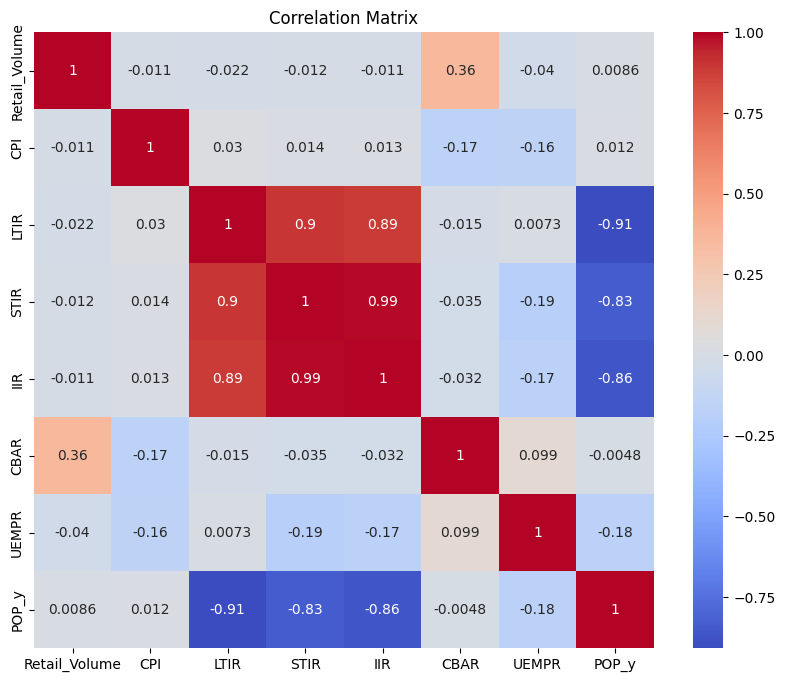

In [307]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'housing_df' is the DataFrame containing the data
# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(reg_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### multicolinearity

When Ri2 is equal to 0, and therefore, when VIF or tolerance is equal to 1, the ith independent variable is not correlated to the remaining ones, meaning that multicollinearity does not exist.

1. In general terms,
    - VIF equal to 1 = variables are not correlated
    - VIF between 1 and 5 = variables are moderately correlated 
    - VIF greater than 5 = variables are highly correlated

2. The higher the VIF, the higher the possibility that multicollinearity exists, and further research is required. When VIF is higher than 10, there is significant multicollinearity that needs to be corrected.

This output shows the VIF value for each predictor variable, indicating multicollinearity levels in the dataset. The const row represents the intercept term, with a VIF close to 1, meaning it has no multicollinearity. Among the predictor variables, Product_range has the highest VIF (5.94), which suggests that it needs corrective measures. All the other predictors have VIF values below 3, indicating low multicollinearity. 



In [308]:
# VIF calculation
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(reg_data)  # Add intercept
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,Variable,VIF
0,const,15457.674438
1,Retail_Volume,1.167646
2,CPI,1.072447
3,LTIR,13.560399
4,STIR,104.675909
5,IIR,107.935708
6,CBAR,1.201200
7,UEMPR,1.878656
8,POP_y,15.127540


In [309]:
reg_data.columns

Index(['Retail_Volume', 'CPI', 'LTIR', 'STIR', 'IIR', 'CBAR', 'UEMPR',
       'POP_y'],
      dtype='object')

In [310]:
selected_features = [ 'CPI', 'LTIR', 'STIR', 'IIR', 'CBAR', 'UEMPR', 'POP_y']
X = reg_data[selected_features]
y = reg_data['Retail_Volume']

You will use Standardization to ensure all features are on the same scale, improving model performance and comparability.



In [311]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the data and transform it
X_scaled = scaler.fit_transform(X)

# Print the scaled data
print(X_scaled)

[[ 0.69932006  0.69843149  0.90171574 ...  0.11685221  3.01239998
  -1.99410449]
 [ 0.42094994  0.81080668  0.8753369  ... -0.52290472  2.80885465
  -1.97857238]
 [ 0.42094994  0.72756998  0.67751757 ... -0.2492369   2.70708199
  -1.96304028]
 ...
 [ 2.92628103  0.03903195 -0.03910551 ...  0.77821458 -1.87268797
   1.37342501]
 [ 0.69932006 -0.06826095  0.18544002 ...  1.01098652 -1.87268797
   1.37342501]
 [-0.69253055 -0.04567297  0.32000524 ... -0.81655958 -1.87268797
   1.37342501]]


#### Model

**Mean Squared Error (MSE):** The MSE measures the average squared difference between the predicted and actual values of the target variable. A lower MSE indicates better model performance, as it means the model is making more accurate predictions

**R-squared (R2):**  R-squared measures the proportion of the variance in the dependent variable that is predictable from the independent variables. It ranges from 0 to 1, where 1 is perfect prediction and 0 indicates no linear relationship



In [312]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# The 'LinearRegression' model is initialized and fitted to the training data.
model = LinearRegression()
model.fit(X_train, y_train)

# The model is used to predict the target variable for the test set.
y_pred = model.predict(X_test)


print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))


Mean Squared Error: 34.02336892875156
R-squared: 0.12176764376862836


#### Homoscedasticity

**Homoscedasticity**: The variance of residuals is constant across all levels of the independent variables. A residual plot can help verify this.

noktalar restgele dağılmalı

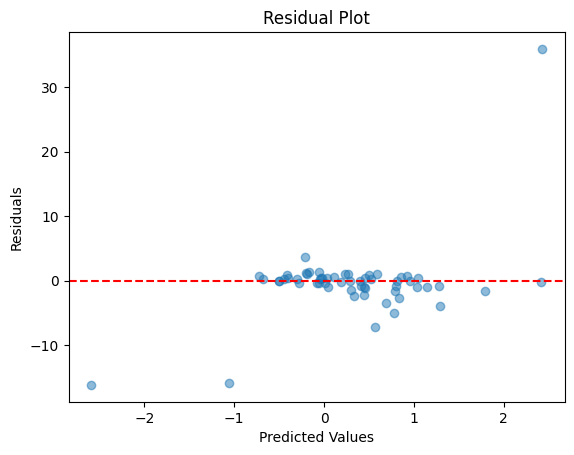

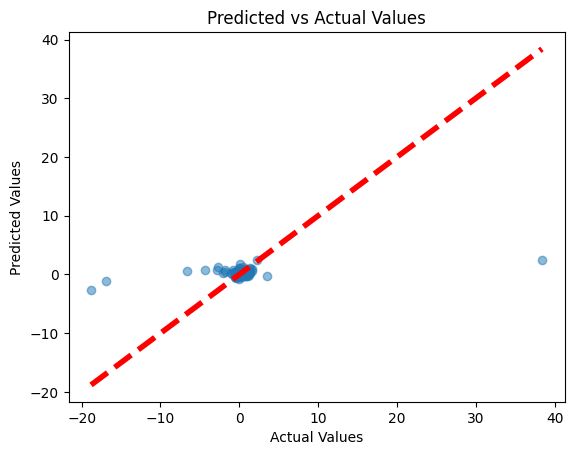

In [313]:
# Residual Plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Predicted vs Actual Plot
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=4)
plt.show()

                            OLS Regression Results                            
Dep. Variable:          Retail_Volume   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     6.682
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           2.53e-07
Time:                        15:37:22   Log-Likelihood:                -749.65
No. Observations:                 287   AIC:                             1515.
Df Residuals:                     279   BIC:                             1545.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.1059     24.484      1.148      0.2

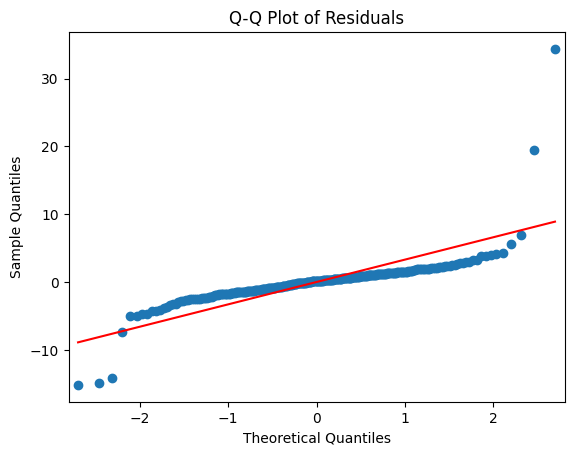

In [314]:
from statsmodels.formula.api import ols

# Add a constant to the model
model_sm = ols('Retail_Volume ~ CPI + LTIR + STIR + IIR + CBAR + UEMPR + POP_y', data=reg_data).fit()
print(model_sm.summary())

# Q-Q Plot for residuals
sm.qqplot(model_sm.resid, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

In [315]:
anova_table = sm.stats.anova_lm(model_sm, typ=2)
print(anova_table)


               sum_sq     df          F        PR(>F)
CPI          6.084347    1.0   0.544062  4.613740e-01
LTIR         9.051579    1.0   0.809392  3.690759e-01
STIR         3.142549    1.0   0.281007  5.964638e-01
IIR          4.058730    1.0   0.362932  5.473719e-01
CBAR       501.417226    1.0  44.836715  1.175584e-10
UEMPR       23.354245    1.0   2.088336  1.495499e-01
POP_y       12.160708    1.0   1.087410  2.979485e-01
Residual  3120.108317  279.0        NaN           NaN


### Permutation importance

In [316]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance


X = reg_data[selected_features]
y = reg_data['Retail_Volume']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression().fit(X_train, y_train)


result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)


importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importance_df)


  feature  importance_mean  importance_std
4    CBAR         0.121049        0.024111
3     IIR         0.025758        0.026109
1    LTIR         0.021365        0.020478
2    STIR         0.014287        0.022319
5   UEMPR         0.009157        0.009486
6   POP_y         0.004831        0.026630
0     CPI         0.000918        0.001537


In [317]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.1296 ± 0.0467,CBAR
0.0460 ± 0.0595,IIR
0.0275 ± 0.0472,LTIR
0.0151 ± 0.0397,POP_y
0.0120 ± 0.0138,UEMPR
0.0007 ± 0.0038,CPI
0.0003 ± 0.0315,STIR


In [318]:
con.close()